# Learning Image Captions with Transformers

In this chapter, we will learn how to use Transformer models to generate image caption generators. We will use,

* A pretrained Vision Transformer model
* A text decoder Transformer model

to generate captions.


In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import collections
import numpy as np
import pandas as pd
import os
import json
from six.moves import range
from six.moves.urllib.request import urlretrieve
import tensorflow as tf
from tokenizers import BertWordPieceTokenizer
import tensorflow_hub as hub
import tensorflow.keras.backend as K
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

## Downloading and Preparing MSCOCO Dataset

Download the datasets from [here](http://cocodataset.org/#download). We will not perform the download through Python scripts, as these are large files. Rather, we'll download manuallly.

Specifically we use,

* Training dataset - [2014 Train images [83K/13GB]](http://images.cocodataset.org/zips/train2014.zip) & [2014 Train/Val annotations [241MB]](http://images.cocodataset.org/annotations/annotations_trainval2014.zip)
* Validation dataset - [2017 Val images [5K/1GB]](http://images.cocodataset.org/zips/val2017.zip) & [2017 Train/Val annotations [241MB]](http://images.cocodataset.org/annotations/annotations_trainval2017.zip)

Once downloaded, 

* Create a folder called `data` in the `Ch11-Image-Caption-Generation` folder
* Copy the downloaded `zip` files to the `data` folder and chose the **Extract to** option (i.e not **Extract here**). You should have the following subfolders now.
  * `data/train2014`
  * `data/annotations_trainval2014`
  * `data/val2017`
  * `data/annotations_trainval2017`

We will split the data in `train2014` to from the training and validation data and use the data in `val2017` as testing data.

### Defining data locations

Below we define the file locations for images and captions for train and test data

In [2]:
trainval_image_dir = os.path.join('data', 'train2014', 'train2014')
trainval_captions_dir = os.path.join('data', 'annotations_trainval2014', 'annotations')
test_image_dir = os.path.join('data', 'val2017', 'val2017')
test_captions_dir = os.path.join('data', 'annotations_trainval2017', 'annotations')

In [3]:
trainval_captions_filepath = os.path.join(trainval_captions_dir, 'captions_train2014.json')
test_captions_filepath = os.path.join(test_captions_dir, 'captions_val2017.json')

## Split training/validation datasets

Here we randomly sample 20% of the data in `train2014` to be validation data

In [4]:
all_filepaths = np.array([os.path.join(trainval_image_dir, f) for f in os.listdir(trainval_image_dir)])
rand_indices = np.arange(len(all_filepaths))
np.random.shuffle(rand_indices)

split = int(len(all_filepaths)*0.8)

train_filepaths, valid_filepaths = all_filepaths[rand_indices[:split]], all_filepaths[rand_indices[split:]] 

print(f"Train dataset size: {len(train_filepaths)}")
print(f"Valid dataset size: {len(valid_filepaths)}")

Train dataset size: 66226
Valid dataset size: 16557


## Processing data

Here we generate the filepaths for the images and read the captions from the `.json` files containing captions. Finally we create three dataframes; `train_captions_df`, `valid_captions_df` and `test_captions_df`.

Each will contain the following columns,
* `image_filepath` - The filepath to the image
* `caption` - The original caption
* `preprocessed_caption` - A preprocessed version of the caption

In [17]:
with open(trainval_captions_filepath, 'r') as f:
    trainval_data = json.load(f)
    
trainval_captions_df = pd.json_normalize(trainval_data, "annotations")
trainval_captions_df["image_filepath"] = trainval_captions_df["image_id"].apply(
    lambda x: os.path.join(trainval_image_dir, 'COCO_train2014_'+format(x, '012d')+'.jpg')
)

def preprocess_captions(image_captions_df):
    """ Preprocessing the captions """
    
    image_captions_df["preprocessed_caption"] = "[START] " + image_captions_df["caption"].str.lower().str.replace('[^\w\s]','') + " [END]"
    return image_captions_df

train_captions_df = trainval_captions_df[trainval_captions_df["image_filepath"].isin(train_filepaths)]
train_captions_df = preprocess_captions(train_captions_df)
valid_captions_df = trainval_captions_df[trainval_captions_df["image_filepath"].isin(valid_filepaths)]
valid_captions_df = preprocess_captions(valid_captions_df)

with open(test_captions_filepath, 'r') as f:
    test_data = json.load(f)
    
test_captions_df = pd.json_normalize(test_data, "annotations")
test_captions_df["image_filepath"] = test_captions_df["image_id"].apply(
    lambda x: os.path.join(test_image_dir, format(x, '012d')+'.jpg')
)
test_captions_df = preprocess_captions(test_captions_df)

train_captions_df.head()

C:\Anaconda3\envs\packt.nlp.tf2\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: The default value of regex will change from True to False in a future version.
  if sys.path[0] == '':
C:\Anaconda3\envs\packt.nlp.tf2\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,image_id,id,caption,image_filepath,preprocessed_caption
0,318556,48,A very clean and well decorated empty bathroom,data\train2014\train2014\COCO_train2014_000000...,[START] a very clean and well decorated empty ...
1,116100,67,A panoramic view of a kitchen and all of its a...,data\train2014\train2014\COCO_train2014_000000...,[START] a panoramic view of a kitchen and all ...
2,318556,126,A blue and white bathroom with butterfly theme...,data\train2014\train2014\COCO_train2014_000000...,[START] a blue and white bathroom with butterf...
3,116100,148,A panoramic photo of a kitchen and dining room,data\train2014\train2014\COCO_train2014_000000...,[START] a panoramic photo of a kitchen and din...
4,379340,173,A graffiti-ed stop sign across the street from...,data\train2014\train2014\COCO_train2014_000000...,[START] a graffitied stop sign across the stre...


## Visualize some data

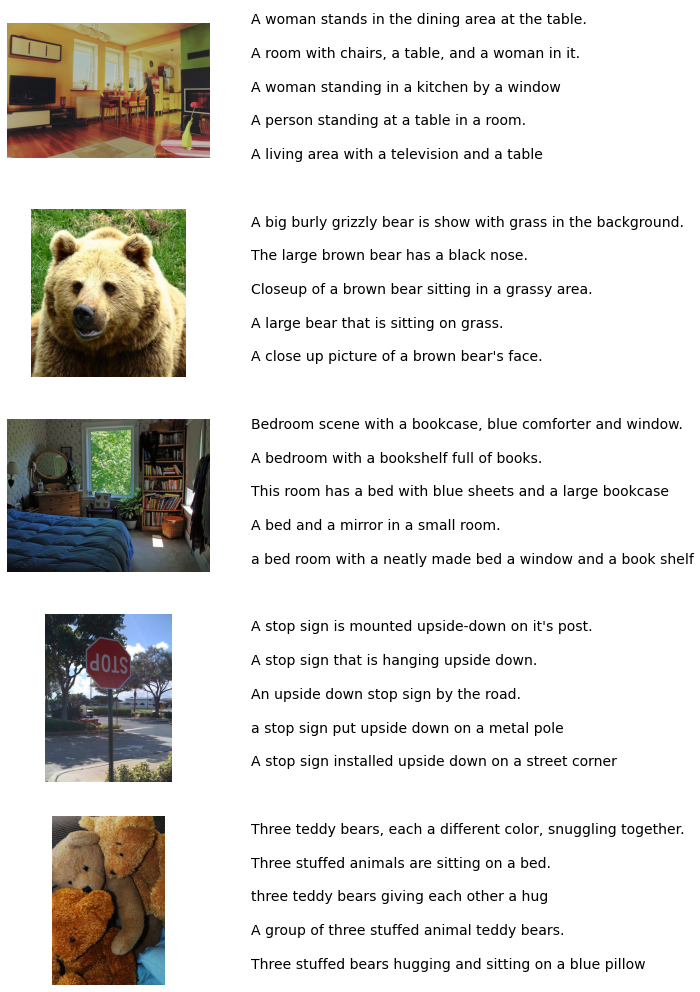

In [32]:
sample_data = test_captions_df.groupby("image_filepath")["caption"].agg(list).iloc[:5]

fig, axes = plt.subplots(5, 2, figsize=(8,18))

for ax_row, index, sample in zip(axes, sample_data.index, sample_data):
    
    ax_row[0].imshow(Image.open(index))
    ax_row[0].axis("off")
    text_y = 0.9
    for cap in sample:
        ax_row[1].text(0, text_y, cap, fontsize=14)
        text_y -= 0.2
    ax_row[1].axis("off")

## Analysing some statistics about the data

In [6]:
from PIL import Image

n_samples = 1000

train_image_stats_df = train_captions_df.loc[:n_samples, "image_filepath"].apply(lambda x: Image.open(x).size)
train_image_stats_df = pd.DataFrame(train_image_stats_df.tolist(), index=train_image_stats_df.index)
train_image_stats_df.describe()

,0,1
count,808.000000,808.000000
mean,571.698020,499.007426
std,95.377281,100.333224
min,332.000000,182.000000
25%,480.000000,427.000000
50%,640.000000,480.000000
75%,640.000000,640.000000
max,640.000000,640.000000


In [16]:
train_vocabulary = train_captions_df["preprocessed_caption"].str.split(" ").explode().value_counts()
print(len(train_vocabulary[train_vocabulary>=25]))

3629


## Understanding the BERT tokenizer

In [33]:
from tokenizers import BertWordPieceTokenizer

# Initialize an empty BERT tokenizer
tokenizer = BertWordPieceTokenizer(
    #reserved_tokens=["[UNK]", "[START]", "[END]", "[PAD]"],
    unk_token="[UNK]",
    #trainer_params=None,
    #vocab_size=8000,
    clean_text=False,
    lowercase=False,
)

tokenizer.train_from_iterator(
    train_captions_df["preprocessed_caption"].tolist(),
    vocab_size=3500,
    special_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
)

In [35]:
# Encoding a sentence
example_captions = valid_captions_df["preprocessed_caption"].iloc[:10].tolist()
example_tokenized_captions = tokenizer.encode_batch(example_captions)

for caption, tokenized_cap in zip(example_captions, example_tokenized_captions):
    print(f"{caption} -> {tokenized_cap.tokens}")

[START] an empty kitchen with white and black appliances [END] -> ['[START]', 'an', 'empty', 'kitchen', 'with', 'white', 'and', 'black', 'appliances', '[END]']
[START] a white square kitchen with tile floor that needs repairs  [END] -> ['[START]', 'a', 'white', 'square', 'kitchen', 'with', 'tile', 'floor', 'that', 'need', '##s', 'rep', '##air', '##s', '[END]']
[START] a few people sit on a dim transportation system  [END] -> ['[START]', 'a', 'few', 'people', 'sit', 'on', 'a', 'dim', 'transport', '##ation', 'system', '[END]']
[START] a person protected from the rain by their umbrella walks down the road [END] -> ['[START]', 'a', 'person', 'prote', '##cted', 'from', 'the', 'rain', 'by', 'their', 'umbrella', 'walks', 'down', 'the', 'road', '[END]']
[START] a white kitchen in a home with the light on [END] -> ['[START]', 'a', 'white', 'kitchen', 'in', 'a', 'home', 'with', 'the', 'light', 'on', '[END]']
[START] a bicycle is parked by a bench at night [END] -> ['[START]', 'a', 'bicycle', 'is

In [34]:
vocab = tokenizer.get_vocab()

for token in ["[UNK]", "[PAD]", "[START]", "[END]"]:
    print(f"{token} -> {vocab[token]}")


[UNK] -> 1
[PAD] -> 0
[START] -> 2
[END] -> 3


## Defining the `tf.data.Dataset` for image captioning

In [45]:
def parse_image(filepath, resize_height, resize_width):
    """ Reading an image from a given filepath """
    
    # Reading the image
    image = tf.io.read_file(filepath)
    # Decode the JPEG, make sure there are 3 channels in the output
    image = tf.io.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # Resize the image to 224x224
    image = tf.image.resize(image, [resize_height, resize_width])
    
    # Bring pixel values to [-1, 1]
    image = image*2.0 - 1.0
        
    return image

    
def generate_tokenizer(captions_df, n_vocab):
    """ Generate the tokenizer with given captions """
    
    # Define the tokenizer
    tokenizer = BertWordPieceTokenizer(
        unk_token="[UNK]",
        clean_text=False,
        lowercase=False,
    )
    
    # Train the tokenizer
    tokenizer.train_from_iterator(
        captions_df["preprocessed_caption"].tolist(),
        vocab_size=n_vocab,
        special_tokens=["[PAD]", "[UNK]", "[START]", "[END]"]
    )
    
    return tokenizer
        
    
def generate_tf_dataset(image_captions_df, tokenizer=None, n_vocab=5000, pad_length=33, batch_size=32, training=False):
    """ Generate the tf.data.Dataset"""
    
    # If the tokenizer is not available, create one
    if not tokenizer:
        tokenizer = generate_tokenizer(image_captions_df, n_vocab)
        
    # Get the caption IDs using the tokenizer
    image_captions_df["caption_token_ids"] = [enc.ids for enc in tokenizer.encode_batch(image_captions_df["preprocessed_caption"])]
    
    vocab = tokenizer.get_vocab()
    
    # Add the padding to short sentences and truncate long ones
    image_captions_df["caption_token_ids"] = image_captions_df["caption_token_ids"].apply(
        lambda x: x+[vocab["[PAD]"]]*(pad_length - len(x) + 2) if pad_length + 2 >= len(x) else x[:pad_length + 1] + [x[-1]]
    ) 
    
    # Create a dataset with images and captions
    dataset = tf.data.Dataset.from_tensor_slices({
        "image_filepath": image_captions_df["image_filepath"],
        "caption_token_ids": np.array(image_captions_df["caption_token_ids"].tolist())
    })
    
    # Each sample in our dataset consists of
    # (image, caption token IDs, position IDs), (caption token IDs offset by 1)
    dataset = dataset.map(
        lambda x: (
            (parse_image(x["image_filepath"], 224, 224), x["caption_token_ids"][:-1], tf.range(pad_length+1, dtype='float32')), x["caption_token_ids"]
        )
    )
    
    # Shuffle and batch data in the training mode
    if training:
        dataset = dataset.shuffle(buffer_size=batch_size*10)
    
    dataset = dataset.batch(batch_size)
    
    return dataset, tokenizer
 
n_vocab=3500
batch_size=2
sample_dataset, sample_tokenizer = generate_tf_dataset(train_captions_df, n_vocab=n_vocab, pad_length=10, batch_size=batch_size, training=True)
for i in sample_dataset.take(1):
    print(i)

C:\Anaconda3\envs\packt.nlp.tf2\lib\site-packages\ipykernel_launcher.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Anaconda3\envs\packt.nlp.tf2\lib\site-packages\ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


((<tf.Tensor: shape=(2, 224, 224, 3), dtype=float32, numpy=
array([[[[-0.2051357 , -0.22082198, -0.31493968],
         [-0.2015593 , -0.21724558, -0.31136328],
         [-0.17017174, -0.18585801, -0.2799757 ],
         ...,
         [-0.29620153, -0.437378  , -0.6155298 ],
         [-0.28843057, -0.41392076, -0.6178423 ],
         [-0.29654706, -0.43772352, -0.62483776]],

        [[-0.20112038, -0.21680665, -0.31092435],
         [-0.19215679, -0.20784307, -0.30409288],
         [-0.17134094, -0.18702722, -0.28898805],
         ...,
         [-0.27791965, -0.42258483, -0.6108201 ],
         [-0.26724863, -0.39890122, -0.6028228 ],
         [-0.2838441 , -0.4093343 , -0.6054127 ]],

        [[-0.18529779, -0.20098406, -0.3029449 ],
         [-0.19215679, -0.20784307, -0.3098039 ],
         [-0.16862738, -0.18431365, -0.2862745 ],
         ...,
         [-0.25880945, -0.39930433, -0.58890283],
         [-0.2580061 , -0.39133948, -0.595261  ],
         [-0.26857728, -0.39406747, -0.59191

## Defining the model

Here we define our model. Our model consists of,
* A vision Transformer - Takes in patches of images as inputs and produce a sequence of output representations for each patch
* A text decoder Transformer - Takes in the final representation of the vision Transformer, along with input caption IDs and predict the next token in the caption for each time step


### Vision Transformer (ViT)

Here we are using a vision Transformer produced by Sayak Paul called `vit_s16_fe`. You can find many different variants of ViT trained by Sayak available [here](https://tfhub.dev/sayakpaul/collections/vision_transformer/1). You can understand what these variants mean in this [paper](https://arxiv.org/pdf/2106.10270.pdf)

In [38]:
K.clear_session()

image_input = tf.keras.layers.Input(shape=(224, 224, 3))
image_encoder = hub.KerasLayer("https://tfhub.dev/sayakpaul/vit_s16_fe/1", trainable=False)
image_features = image_encoder(image_input)
print(f"Final representation shape: {image_features.shape}")


Final representation shape: (None, 384)


### The text decoder Transformer

Here we define the text decoder. It takes the final image representation of ViT and concatenate that with caption IDs. Then we predict caption token ID from the next time step with the decoder.

In [39]:
class SelfAttentionLayer(tf.keras.layers.Layer):
    """ Defines the computations in the self attention layer """
    
    def __init__(self, d):        
        super(SelfAttentionLayer, self).__init__()
        # Feature dimensionality of the output
        self.d = d
    
    def build(self, input_shape):
        # Query weight matrix
        self.Wq = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )        
        # Key weight matrix
        self.Wk = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
        # Value weight matrix
        self.Wv = self.add_weight(
            shape=(input_shape[-1], self.d), initializer='glorot_uniform',
            trainable=True, dtype='float32'
        )
    
    def call(self, q_x, k_x, v_x, mask=None):
        
        q = tf.matmul(q_x,self.Wq) #[None, t, d]
        k = tf.matmul(k_x,self.Wk) #[None, t, d]
        v = tf.matmul(v_x,self.Wv) #[None, t, d]
        
        # Computing the final output
        h = tf.keras.layers.Attention(causal=True)([
            q, #q
            v, #v
            k, #k
        ], mask=[None, mask]) # [None, t, t] . [None, t, d] => [None, t, d]
        
        return h
    
    
class TransformerDecoderLayer(tf.keras.layers.Layer):
    """ The Decoder layer """
    
    def __init__(self, d, n_heads):
        super(TransformerDecoderLayer, self).__init__()
        # Feature dimensionality
        self.d = d
        
        # Dimensionality of a head
        self.d_head = int(d/n_heads) 
        
        # Number of heads
        self.n_heads = n_heads
        
        # Actual attention heads
        self.attn_heads = [SelfAttentionLayer(self.d_head) for i in range(self.n_heads)]
        
        # Fully connected layers
        self.fc1_layer = tf.keras.layers.Dense(512, activation='relu')
        self.fc2_layer = tf.keras.layers.Dense(d)
        
        self.add_layer = tf.keras.layers.Add()
        self.norm1_layer = tf.keras.layers.LayerNormalization()
        self.norm2_layer = tf.keras.layers.LayerNormalization()
        
    
    def _compute_multihead_output(self, x):
        """ Computing the multi head attention output"""
        outputs = [head(x, x, x) for head in self.attn_heads]            
        outputs = tf.concat(outputs, axis=-1)
        return outputs
        
    def call(self, x):
        
        
        # Multi head attention layer output
        h1 = self._compute_multihead_output(x)
        
        h1_add = self.add_layer([x, h1])
        h1_norm = self.norm1_layer(h1_add)
        
        # Fully connected outputs
        h2_1 = self.fc1_layer(h1_norm)
        h2_2 = self.fc2_layer(h2_1)
        
        h2_add = self.add_layer([h1, h2_2])
        h2_norm = self.norm2_layer(h2_add)
        
        
        return h2_norm
    

# Input layer
caption_input = tf.keras.layers.Input(shape=(None,))
position_input = tf.keras.layers.Input(shape=(None,))
d_model = 384

# Token embeddings
input_embedding = tf.keras.layers.Embedding(len(tokenizer.get_vocab()), d_model, mask_zero=True)

# Position embeddings
position_embedding = tf.keras.layers.Lambda(
    lambda x: tf.where(
        tf.math.mod(tf.repeat(tf.expand_dims(x, axis=-1), d_model, axis=-1), 2)==0,
        tf.math.sin(
            tf.repeat(tf.expand_dims(x, axis=-1), d_model, axis=-1) /
            10000**(2*tf.reshape(tf.range(d_model, dtype='float32'),[1,1, -1])/d_model)
        ),
        tf.math.cos(
            tf.repeat(tf.expand_dims(x, axis=-1), d_model, axis=-1) /
            10000**(2*tf.reshape(tf.range(d_model, dtype='float32'),[1,1, -1])/d_model)
        )
    )
)

# Combined token position embeddings
embed_out = input_embedding(caption_input) + position_embedding(position_input)
# Concatenate image caption and token embeddings
image_caption_embed_out = tf.keras.layers.Concatenate(axis=1)([tf.expand_dims(image_features,axis=1), embed_out])

# Generate hidden representation with Transformer decoder layer
out = image_caption_embed_out
for l in range(4):
    out  = TransformerDecoderLayer(d_model, 64)(out)

# Final prediction layer
final_out = tf.keras.layers.Dense(n_vocab, activation='softmax')(out)

# Define the final model and compile
full_model = tf.keras.models.Model(inputs=[image_input, caption_input, position_input], outputs=final_out)
full_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics='accuracy')

full_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 keras_layer (KerasLayer)       (None, 384)          21665664    ['input_1[0][0]']            

## Training the model

Here we define the BLEU metric to measure the quality of captions generated.

In [40]:
from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from bleu import compute_bleu

class BLEUMetric(object):
    
    def __init__(self, tokenizer, name='bleu_metric', **kwargs):
      """ Computes the BLEU score (Metric for machine translation) """
      super().__init__()
      self.tokenizer = tokenizer
    
      #self.vocab = vocabulary
      #self.id_to_token_layer = StringLookup(vocabulary=self.vocab, num_oov_indices=0, oov_token='[UNKUNK]', invert=True)
    
    def calculate_bleu_from_predictions(self, real, pred):
        """ Calculate the BLEU score for targets and predictions """
        
        # Get the predicted token IDs
        pred_argmax = tf.argmax(pred, axis=-1)  
        
        # Convert token IDs to words using the vocabulary and the StringLookup
        pred_tokens = np.array([[self.tokenizer.id_to_token(pp) for pp in p] for p in pred_argmax])
        real_tokens = tf.constant([[self.tokenizer.id_to_token(rr) for rr in r] for r in real])
        
        def clean_text(tokens):
            
            """ Clean padding and <s>/</s> tokens to only keep meaningful words """
            
            # 3. Strip the string of any extra white spaces
            translations_in_bytes = tf.strings.strip(
                        # 2. Replace everything after the eos token with blank
                        tf.strings.regex_replace(
                            # 1. Join all the tokens to one string in each sequence
                            tf.strings.join(
                                tf.transpose(tokens), separator=' '
                            ),
                        "[END]*", ""),
                   )
            
            # Decode the byte stream to a string
            translations = np.char.decode( #
                translations_in_bytes.numpy().astype(np.bytes_), encoding='utf-8'
            )
            
            # If the string is empty, add a [UNK] token
            # Otherwise get a Division by zero error
            translations = [sent if len(sent)>0 else "[UNK]" for sent in translations ]
            
            # Split the sequences to individual tokens 
            translations = np.char.split(translations).tolist()
            
            return translations
        
        # Get the clean versions of the predictions and real seuqences
        pred_tokens = clean_text(pred_tokens)
        # We have to wrap each real sequence in a list to make use of a function to compute bleu
        real_tokens = [[token_seq] for token_seq in clean_text(real_tokens)]

        # The compute_bleu method accpets the translations and references in the following format
        # tranlation - list of list of tokens
        # references - list of list of list of tokens
        bleu, precisions, bp, ratio, translation_length, reference_length = compute_bleu(real_tokens, pred_tokens, smooth=False)

        return bleu

In [41]:
batch_size=96

train_fraction = 0.6
valid_fraction = 0.25

tokenizer = generate_tokenizer(
    train_captions_df, n_vocab=n_vocab
)

bleu_metric = BLEUMetric(tokenizer=tokenizer)

sampled_validation_captions_df = valid_captions_df.sample(frac=valid_fraction)

for e in range(5):
    print(f"Epoch: {e+1}")
    
    train_dataset, _ = generate_tf_dataset(
        train_captions_df.sample(frac=train_fraction), tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=True
    )
    valid_dataset, _ = generate_tf_dataset(
        sampled_validation_captions_df, tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=False
    )
    
    full_model.fit(
        train_dataset,
        epochs=1
    )
    
    valid_loss, valid_accuracy, valid_bleu = [], [], []
    for vi, v_batch in enumerate(valid_dataset):
        print(f"{vi+1} batches processed", end='\r')
        loss, accuracy = full_model.test_on_batch(v_batch[0], v_batch[1])
        batch_predicted = full_model(v_batch[0])
        bleu_score = bleu_metric.calculate_bleu_from_predictions(v_batch[1], batch_predicted)
        valid_loss.append(loss)
        valid_accuracy.append(accuracy)
        valid_bleu.append(bleu_score)
        
    print(
        f"\nvalid_loss: {np.mean(valid_loss)} - valid_accuracy: {np.mean(valid_accuracy)} - valid_bleu: {np.mean(valid_bleu)}"
    )

Epoch: 1
2071/2071 [==============================] - 2218s 1s/step - loss: 1.3307 - accuracy: 0.7616
216 batches processed
valid_loss: 1.1565554020581421 - valid_accuracy: 0.7783137681307616 - valid_bleu: 0.6939420931746384
Epoch: 2
2071/2071 [==============================] - 2044s 986ms/step - loss: 1.1117 - accuracy: 0.7830
216 batches processed
valid_loss: 1.1051980875156544 - valid_accuracy: 0.7842627040765904 - valid_bleu: 0.698833629935969
Epoch: 3
2071/2071 [==============================] - 1904s 919ms/step - loss: 1.0813 - accuracy: 0.7860
216 batches processed
valid_loss: 1.0859504055093836 - valid_accuracy: 0.7867717974715762 - valid_bleu: 0.7001576094122058
Epoch: 4
2071/2071 [==============================] - 1904s 919ms/step - loss: 1.0763 - accuracy: 0.7860
216 batches processed
valid_loss: 1.1032822079680584 - valid_accuracy: 0.7836998455502369 - valid_bleu: 0.6982947262491402
Epoch: 5
2071/2071 [==============================] - 1910s 922ms/step - loss: 1.0831 - accu

## Evaluating the Test dataset

In [44]:
bleu_metric = BLEUMetric(tokenizer=tokenizer)

test_dataset, _ = generate_tf_dataset(
    test_captions_df, tokenizer=tokenizer, n_vocab=n_vocab, batch_size=batch_size, training=False
)

test_loss, test_accuracy, test_bleu = [], [], []
for ti, t_batch in enumerate(test_dataset):
    print(f"{ti+1} batches processed", end='\r')
    loss, accuracy = full_model.test_on_batch(t_batch[0], t_batch[1])
    batch_predicted = full_model.predict_on_batch(t_batch[0])
    bleu_score = bleu_metric.calculate_bleu_from_predictions(t_batch[1], batch_predicted)
    test_loss.append(loss)
    test_accuracy.append(accuracy)
    test_bleu.append(bleu_score)

print(
    f"\ntest_loss: {np.mean(test_loss)} - test_accuracy: {np.mean(test_accuracy)} - test_bleu: {np.mean(test_bleu)}"
)

261 batches processed
test_loss: 1.1122150994351998 - test_accuracy: 0.7833092605473895 - test_bleu: 0.698813674603171


## Generating image captions 

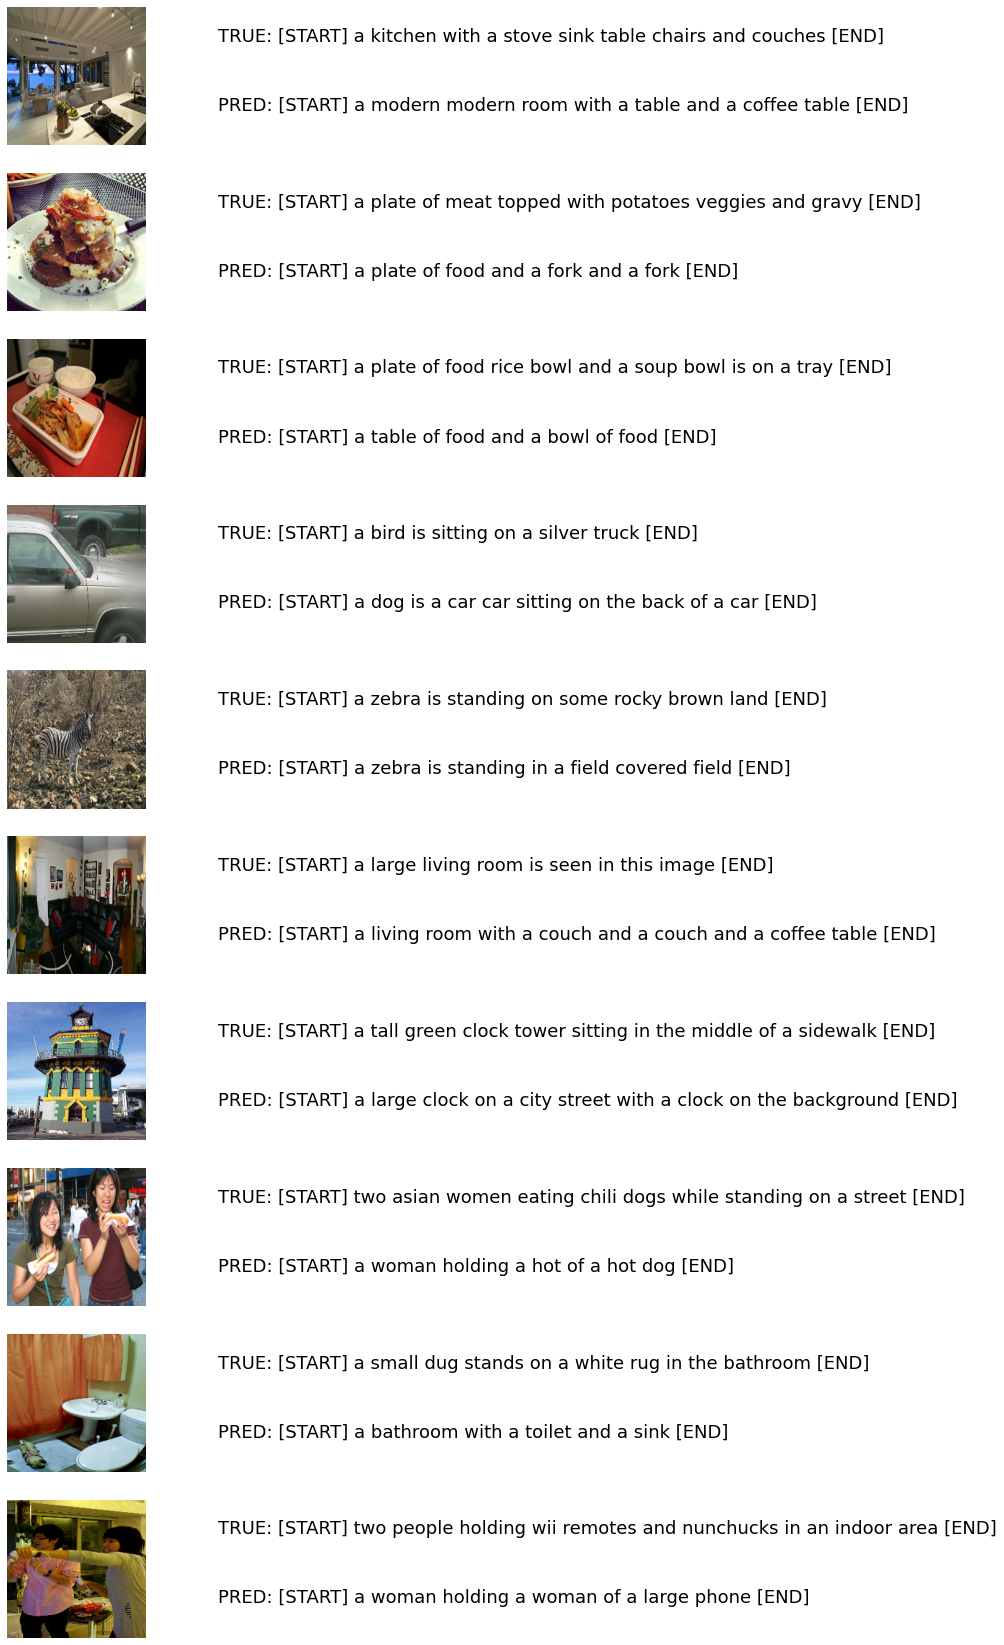

In [43]:
reverse_vocab = dict([(v,k) for k,v in tokenizer.get_vocab().items()])

n_samples = 10
test_dataset, _ = generate_tf_dataset(
    test_captions_df.sample(n=n_samples), tokenizer=tokenizer, n_vocab=n_vocab, batch_size=n_samples, training=False
)

def generate_caption(model, image_input, tokenizer, n_samples):
    # 2 -> [START]
    batch_tokens = np.array([[2]])
    
    for i in range(30):
        if np.all(batch_tokens[:,-1] == 3):
            break
            
        position_input = tf.repeat(tf.reshape(tf.range(i+1),[1,-1]), n_samples, axis=0)
        probs = full_model((image_input, batch_tokens, position_input)).numpy()
        batch_tokens = np.argmax(probs, axis=-1)
    
    predicted_text = []
    for sample_tokens in batch_tokens:
        sample_predicted_token_ids = sample_tokens.ravel()
        sample_predicted_tokens = []
        for wid in sample_predicted_token_ids:
            sample_predicted_tokens.append(tokenizer.id_to_token(wid))
            if wid == 3:
                break
        sample_predicted_text = " ".join([tok for tok in sample_predicted_tokens])
        sample_predicted_text = sample_predicted_text.replace(" ##", "")
        predicted_text.append(sample_predicted_text)
    
    return predicted_text
    
    
for batch in test_dataset.take(1):
    (batch_image_input, _, _), batch_true_caption = batch

batch_predicted_text = generate_caption(full_model, batch_image_input, tokenizer, n_samples)

fig, axes = plt.subplots(n_samples, 2, figsize=(8,30))

for i,(sample_image_input, sample_true_caption, sample_predicated_caption) in enumerate(zip(batch_image_input, batch_true_caption, batch_predicted_text)):
    
    sample_true_caption_tokens  = [tokenizer.id_to_token(wid) for wid in sample_true_caption.numpy().ravel()]
    
    sample_true_text = []
    for tok in sample_true_caption_tokens:
        sample_true_text.append(tok)
        if tok == '[END]':
            break
    
    sample_true_text = " ".join(sample_true_text).replace(" ##", "")
    axes[i][0].imshow(((sample_image_input.numpy()+1.0)/2.0))
    axes[i][0].axis('off')
    
    true_annotation = f"TRUE: {sample_true_text}"
    predicted_annotation = f"PRED: {sample_predicated_caption}"
    axes[i][1].text(0, 0.75, true_annotation, fontsize=18)
    axes[i][1].text(0, 0.25, predicted_annotation, fontsize=18)
    axes[i][1].axis('off')


